In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 785.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.6 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
# Load the dataset

data = pd.read_csv(
    "/content/IMDB Dataset.csv",
)


# Preprocessing the data

In [5]:
data.replace({"sentiment":{"positive":1,"negative":0}},inplace=True)

/tmp/ipython-input-3877186056.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"sentiment":{"positive":1,"negative":0}},inplace=True)


In [6]:
# removing duplicates

# print(data.duplicated().sum() + "duplicates in dataset")
data.drop_duplicates(inplace=True)

In [7]:
data['review']=data['review'].str.lower()

In [8]:
# Remove HTML tags from reviews
import re
def remove_html_tags(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text
data['review'] = data['review'].apply(remove_html_tags)

In [9]:
# Remove stopwords from reviews
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Intilize Stopwords
stop_words = set(stopwords.words('english'))

data['review'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stop_words)]))

# Remove URLs from reviews
data['review'] = data['review'].str.replace(r'http\S+|www\.\S+', '', case=False, regex=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Tokenizing

In [11]:
tokenizer=Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [12]:
# target variables
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

# LSTM model

In [13]:
model = Sequential()
model.add(Embedding(input_dim=5000,output_dim=128, input_shape=(200,)))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [16]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 115s 227ms/step - accuracy: 0.7683 - loss: 0.4660 - val_accuracy: 0.8703 - val_loss: 0.3150
Epoch 2/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 112s 226ms/step - accuracy: 0.8934 - loss: 0.2655 - val_accuracy: 0.8784 - val_loss: 0.3100
Epoch 3/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 112s 227ms/step - accuracy: 0.9156 - loss: 0.2200 - val_accuracy: 0.8771 - val_loss: 0.3227
Epoch 4/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 113s 227ms/step - accuracy: 0.9263 - loss: 0.1904 - val_accuracy: 0.8756 - val_loss: 0.3287
Epoch 5/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 114s 230ms/step - accuracy: 0.9419 - loss: 0.1530 - val_accuracy: 0.8671 - val_loss: 0.3582


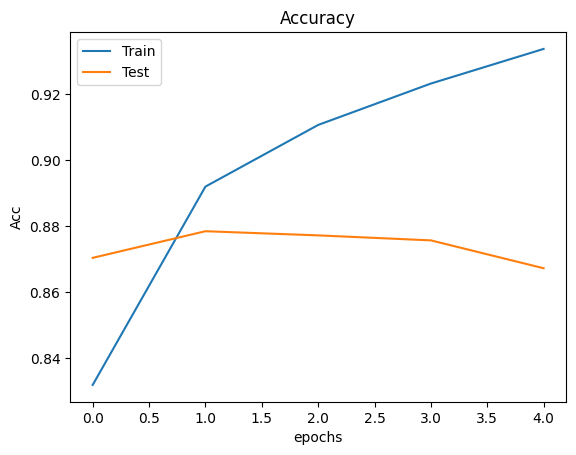

In [17]:
# Plot training and validation accuracy
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [18]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8675 - loss: 0.3626
Test Loss: 0.3571610152721405
Test Accuracy: 0.8723404407501221


# Logistic Regression

In [19]:
# Import libraries for Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [20]:
# Prepare data for Logistic Regression
A = data['review']
B = data['sentiment']

In [21]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(A,B, test_size=0.2, random_state=42)

In [22]:
# Transform text data using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [23]:
# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_tfidf, Y_train)

LogisticRegression(max_iter=500)

In [24]:
# Make Predictions
y_pred = log_reg.predict(X_test_tfidf)

# Evaluate Logistic Regression model
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.88


In [25]:
# Import pickle to save models
import pickle

In [26]:
# Save tokenizer
pickle.dump(tokenizer ,open('tokenizer.pkl' , 'wb'))

In [27]:
# Save LSTM model
pickle.dump(model ,open('model.pkl' , 'wb'))